# Mobike 上海数据分析
## by   郑 浩

## 初步清洗

> 我们在互联网上获取了Mobile 2016年8月份上海地区的运营数据，通过简单的清洗，对数据整理，再利用python的制图类分析工具，对整理后的数据进行分析，得到一些有价值的结论。

In [1]:
# 导入需要的库
import pandas as pd
import numpy as np
import datetime, time
import calendar
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.ticker as tick
from math import sin, cos, sqrt, atan2, radians

In [2]:
# 导入数据，并进行查看
df = pd.read_csv('mobike_shanghai_sample_updated.csv')
df.head(5)

,orderid,bikeid,userid,start_time,start_location_x,start_location_y,end_time,end_location_x,end_location_y,track
0,78387,158357,10080,2016-08-20 06:57,121.348,31.389,2016-08-20 07:04,121.357,31.388,"121.347,31.392#121.348,31.389#121.349,31.390#1..."
1,891333,92776,6605,2016-08-29 19:09,121.508,31.279,2016-08-29 19:31,121.489,31.271,"121.489,31.270#121.489,31.271#121.490,31.270#1..."
2,1106623,152045,8876,2016-08-13 16:17,121.383,31.254,2016-08-13 16:36,121.405,31.248,"121.381,31.251#121.382,31.251#121.382,31.252#1..."
3,1389484,196259,10648,2016-08-23 21:34,121.484,31.320,2016-08-23 21:43,121.471,31.325,"121.471,31.325#121.472,31.325#121.473,31.324#1..."
4,188537,78208,11735,2016-08-16 07:32,121.407,31.292,2016-08-16 07:41,121.418,31.288,"121.407,31.291#121.407,31.292#121.408,31.291#1..."


In [3]:
list(df)

['orderid',
 'bikeid',
 'userid',
 'start_time',
 'start_location_x',
 'start_location_y',
 'end_time',
 'end_location_x',
 'end_location_y',
 'track']

In [4]:
df.shape

(102361, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102361 entries, 0 to 102360
Data columns (total 10 columns):
orderid             102361 non-null int64
bikeid              102361 non-null int64
userid              102361 non-null int64
start_time          102361 non-null object
start_location_x    102361 non-null float64
start_location_y    102361 non-null float64
end_time            102361 non-null object
end_location_x      102361 non-null float64
end_location_y      102361 non-null float64
track               102361 non-null object
dtypes: float64(4), int64(3), object(3)
memory usage: 7.8+ MB


## 数据集的机构

>+ 数据主要包括时间、地点和用户信息   
+ 时间信息是浮点类型，需要转换成时间格式，位置是坐标信息可以调整成距离信息       
+ 时间信息包含起止，可以做一些拆解和计算获得有价值的信息，距离信息也可以进行分析

## 数据分析点

>+ 可以对距离进行统计分析   
+ 对骑行时间进行统计分析       
+ 对车辆和用户信息进行统计分析

## 数据支撑点

>+ 不同起止位置的坐标可以转化成位置信息，相减取绝对值获得距离信息   
+ 从时间格式中提取不同时间维度的信息，也可以通过运算获得时长信息       
+ 用户的ID、订单的ID以及车辆的ID可以统计使用的频率

In [6]:
# 对日期格式进行整理并重新分组
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df = df.sort_values(by = 'start_time')
df['start_month_num'] = df['start_time'].apply(lambda time: time.month)
df['start_month_abbr'] = df['start_month_num'].apply(lambda x: calendar.month_abbr[x])
df['start_weekday_num'] = df['start_time'].apply(lambda time: time.dayofweek)
weekday = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['start_weekday_abbr'] = df['start_weekday_num'].map(weekday)
df['start_time_year&mouth']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year&mouth']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))
df['start_time_year']=df['start_time'].dt.year.astype(int)
df['end_time_year']=df['end_time'].dt.year.astype(int)
df['start_time_mouth']=df['start_time'].dt.month.astype(int)
df['end_time_mouth']=df['end_time'].dt.month.astype(int)
df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date
df['start_time_year_month_day_renamed'] = df['start_time'].dt.strftime('%y' + '-' + '%m' + '-' + '%d')

In [7]:
df['start_month_abbr'].value_counts()

Aug    102361
Name: start_month_abbr, dtype: int64

In [8]:
df['start_weekday_abbr'].value_counts()

Wed    17829
Mon    16380
Tue    16259
Sat    13359
Fri    13208
Sun    12842
Thu    12484
Name: start_weekday_abbr, dtype: int64

In [9]:
df['start_hour'] = df['start_time'].apply(lambda time: time.hour)
df['period_day'] = 'night'
df['period_day'][(df['start_time_hour'] >= 12) & (df['start_time_hour'] <= 18)] = 'afternoon'
df['period_day'][(df['start_time_hour'] >= 6) & (df['start_time_hour'] <=12)] = 'morning'

D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
df['start_hour'].value_counts()

18    10125
17     9279
19     9002
8      8490
20     7468
7      6315
21     5991
16     5379
9      5208
15     4411
13     4214
12     4155
14     3962
22     3867
11     3703
10     3675
6      2297
23     1899
0       945
1       606
5       513
2       399
4       231
3       227
Name: start_hour, dtype: int64

In [11]:
df['period_day'].value_counts()

afternoon    37370
morning      33843
night        31148
Name: period_day, dtype: int64

In [12]:
dict_order = {'period_day': ['morning', 'afternoon', 'night'],
              'start_weekday_char': ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']}

In [13]:
df['duration'] = df['end_time']-df['start_time']

In [14]:
df['duration'].describe()

count                    102361
mean     0 days 00:17:11.709733
std      0 days 00:34:02.995113
min             0 days 00:01:00
25%             0 days 00:07:00
50%             0 days 00:12:00
75%             0 days 00:20:00
max             3 days 06:45:00
Name: duration, dtype: object

In [15]:
df['duration']

91307    00:09:00
15161    00:15:00
67939    00:15:00
94977    00:20:00
47303    00:13:00
           ...   
93657    00:15:00
44314    00:26:00
100128   00:50:00
16723    00:39:00
66587    00:33:00
Name: duration, Length: 102361, dtype: timedelta64[ns]

In [16]:
df['duration_sec'] = df['duration'].dt.seconds

In [17]:
# 将坐标信息转化成距离信息

# def geodistance(location_x1,location_y1,location_x2,location_y2):
#     location_x1, location_y1, location_x2, location_y2 = map(radians, [location_x1, location_y1, location_x2, location_y2])
#     dlon=location_x2-location_x1
#     dlat=location_y2-location_y1
#     a=sin(dlat/2)**2 + cos(location_y1) * cos(location_y2) * sin(dlon/2)**2 
#     dis=2*asin(sqrt(a))*6371*1000
#     return dis

def distance(p1, p2):
    """Takes points in [lon,lat] form and returns the distance in km between them."""
    # approximate radius of earth in km
    R = 6373.0

    lon1 = radians(abs(p1[0]))
    lat1 = radians(abs(p1[1]))
    lon2 = radians(abs(p2[0]))
    lat2 = radians(abs(p2[1]))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [18]:
df['distance_km'] = df.apply(lambda i : distance([i['start_location_x'],i['start_location_y']],
                                                 [i['end_location_x'],i['end_location_y']]),axis=1)

In [19]:
# 保存清理清理后的数据
df.to_csv("2016-Mobike-tripdata-clean.csv", index=False)

In [20]:
# 对ID信息进行整理
count_of_rides = df.groupby('start_time_year_month_day_renamed')['bikeid'].size().reset_index().rename(columns={'bikeid':'count_of_bikeid'})
count_of_rides

,start_time_year_month_day_renamed,count_of_bikeid
0,16-08-01,1827
1,16-08-02,1457
2,16-08-03,1890
3,16-08-04,1707
4,16-08-05,1548
5,16-08-06,2184
6,16-08-07,2095
7,16-08-08,2568
8,16-08-09,2635
9,16-08-10,2972


In [21]:
count_of_unique_rides = df.groupby('start_time_year_month_day_renamed')['bikeid'].nunique().reset_index().rename(columns={'bikeid':'count_of_unique_bikeid'})
count_of_unique_rides

,start_time_year_month_day_renamed,count_of_unique_bikeid
0,16-08-01,1785
1,16-08-02,1422
2,16-08-03,1849
3,16-08-04,1682
4,16-08-05,1527
5,16-08-06,2131
6,16-08-07,2034
7,16-08-08,2512
8,16-08-09,2577
9,16-08-10,2904


In [22]:
df_count_of_rides = count_of_rides.merge(count_of_unique_rides, on='start_time_year_month_day_renamed')

In [23]:
df_count_of_rides['number_of_used'] = df_count_of_rides['count_of_bikeid']/df_count_of_rides['count_of_unique_bikeid']
df_count_of_rides['number_of_used']

0     1.023529
1     1.024613
2     1.022174
3     1.014863
4     1.013752
5     1.024871
6     1.029990
7     1.022293
8     1.022507
9     1.023416
10    1.020057
11    1.016268
12    1.029033
13    1.020154
14    1.024136
15    1.024383
16    1.020140
17    1.020181
18    1.017641
19    1.022462
20    1.016756
21    1.015916
22    1.016133
23    1.020215
24    1.014390
25    1.018313
26    1.023560
27    1.021554
28    1.020269
29    1.016756
30    1.019311
Name: number_of_used, dtype: float64

In [24]:
user_rides = df.groupby('userid')['bikeid'].size().reset_index().rename(columns={'bikeid':' frequency_of_userrides'})
user_rides.describe()

,userid,frequency_of_userrides
count,16887.000000,16887.000000
mean,8735.071475,6.061527
std,5039.687049,3.480024
min,1.000000,1.000000
25%,4388.500000,3.000000
50%,8723.000000,6.000000
75%,13033.500000,8.000000
max,17753.000000,25.000000


## 单变量探索

我们首先对用户的使用频率进行探索

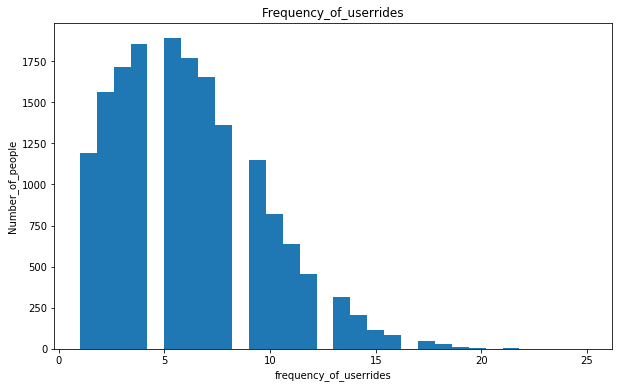

In [25]:
# 月度的用户使用频率分布
plt.figure(figsize=(10,6))
color1 = sb.color_palette()[0]
plt.hist(data=user_rides, x=' frequency_of_userrides', bins=30)
plt.xlabel('frequency_of_userrides')
plt.ylabel('Number_of_people')
plt.title('Frequency_of_userrides');

> 我们发现用户一个月使用最多的次数是5次，随着次数的增加，骑行人数也越来越少

对每周骑车的比率进行分析

In [26]:
# 每周各天骑行数量占全周的比率分布
trip_by_weekday_df = df.groupby('start_weekday_abbr').agg({'bikeid':'count'})
trip_by_weekday_df['perc'] = (trip_by_weekday_df['bikeid']/trip_by_weekday_df['bikeid'].sum())*100
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

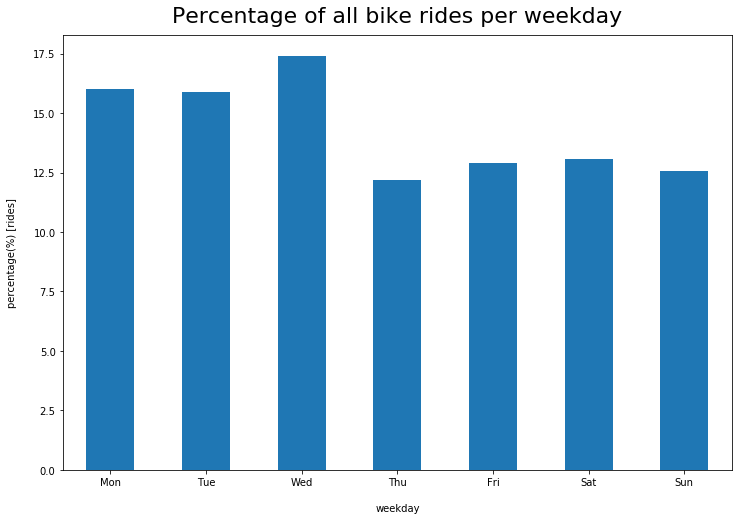

In [27]:
trip_by_weekday_df.reindex(weekday_index)['perc'].plot(kind='bar', color=color1, figsize=(12,8), legend=False)
plt.title('Percentage of all bike rides per weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)

每周各天骑行总时长分析

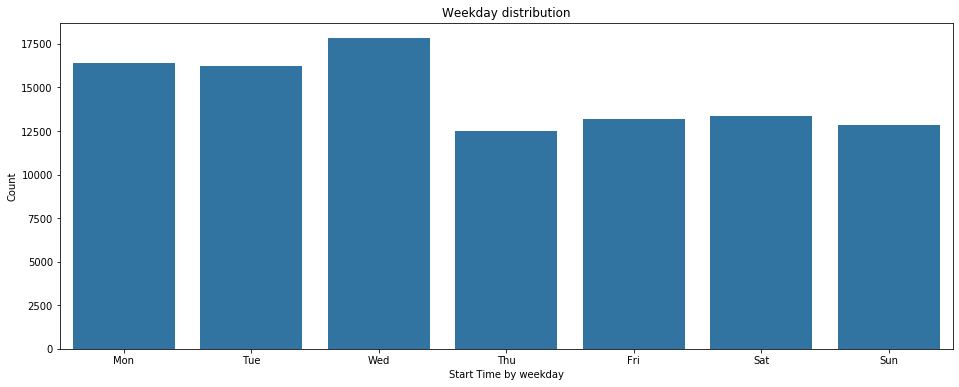

In [28]:
# 8月份每周各天的总骑行时长分布
plt.figure(figsize=(16,6))
sb.countplot(data=df, x='start_weekday_abbr', color=color1, linewidth = 5)
plt.xlabel('Start Time by weekday')
plt.ylabel('Count')
plt.title('Weekday distribution');

> 在一周内，前三天的骑行数量要多于后四天，周三是一个使用的高峰日

全月车辆骑行的数据分析

Text(0, 0.5, 'count [rides]')

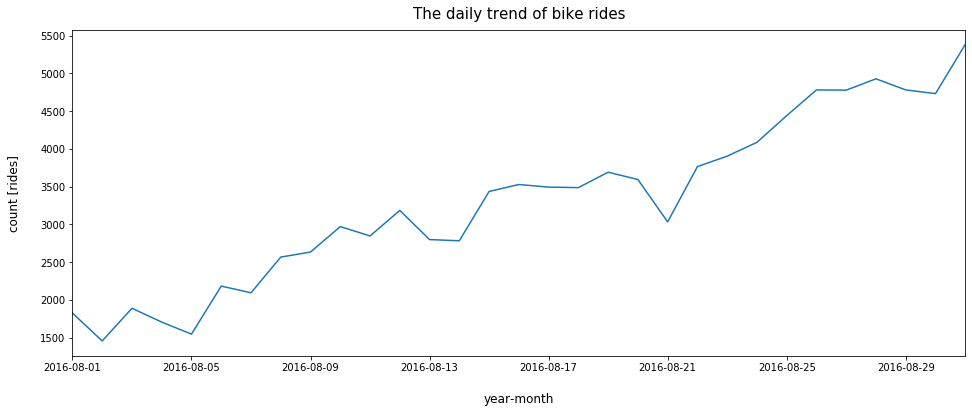

In [29]:
# 每天车辆骑行的趋势图
df.groupby('start_time_date').agg({'bikeid':'count'}).plot(style='-', legend=False, figsize=(16,6))
plt.title('The daily trend of bike rides', fontsize=15, y=1.015)
plt.xlabel('year-month', labelpad=20, fontsize=12)
plt.ylabel('count [rides]', labelpad=20, fontsize=12)

> 摩拜单车一个月骑行数据增长了近三倍，趋势明显

一天中各个时段的统计分析

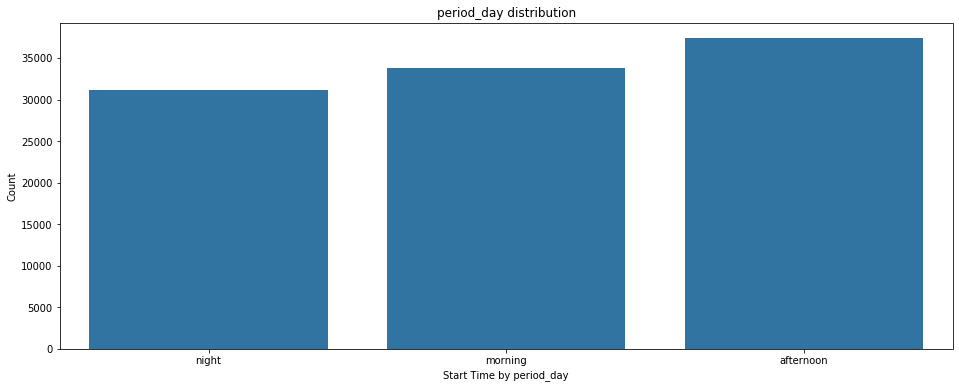

In [30]:
# 一天中各时段骑行数量的分布
plt.figure(figsize=(16,6))
color2 = sb.color_palette()[1]
sb.countplot(data=df, x='period_day', color=color1, linewidth=5)
plt.xlabel('Start Time by period_day')
plt.ylabel('Count')
plt.title('period_day distribution');

> 我们发现下午的骑行数量是最多，这也是人类活动比较集中的时间，早上的数据高于晚上，也是因为有早高峰的存在

一天中各个小时的骑行数据分析

Text(0, 0.5, 'percentage(%) [rides]')

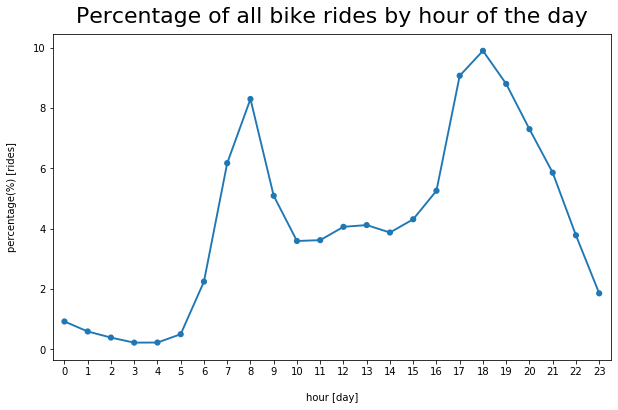

In [31]:
# 一天中个小时骑行比例的分布
trip_by_hour_df = df.groupby('start_time_hour').agg({'bikeid':'count'}).reset_index()
trip_by_hour_df['bikeid'] =(trip_by_hour_df['bikeid']/trip_by_hour_df['bikeid'].sum())*100
plt.figure(figsize=(10,6))
sb.pointplot(x='start_time_hour', y='bikeid', scale=.7, color=color1, data=trip_by_hour_df)
plt.title('Percentage of all bike rides by hour of the day', fontsize=22, y=1.015)
plt.xlabel('hour [day]', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)

> 我们发现晚高峰的骑行数量高于早高峰，8月份的炎热也有可能导致中午时段的骑行数量下降

对用户持续骑行时长进行分析

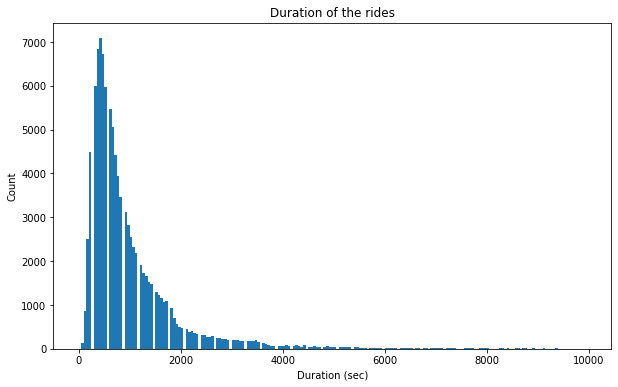

In [32]:
# 行程的持续时间分布
plt.figure(figsize=(10,6))
bins = np.arange(0, 10000, 50)
plt.hist(data=df, x='duration_sec', bins=bins)
plt.xlabel('Duration (sec)')
plt.ylabel('Count')
plt.title('Duration of the rides');

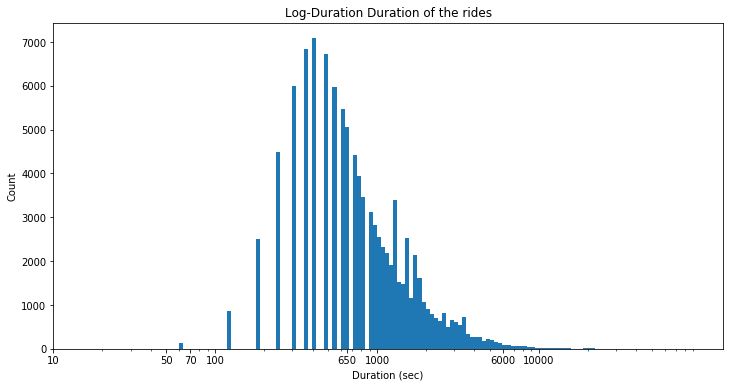

In [33]:
log_binsize = 0.025
bins = 10 ** np.arange(1.2, np.log10(df['duration_sec'].max())+log_binsize, log_binsize)
plt.figure(figsize=[12, 6])
plt.hist(data = df, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([10,50,70,100,650,1000,6000,10000], [10,50,70,100,650,1000,6000,10000])
plt.xlabel('Duration (sec)')
plt.ylabel('Count')
plt.title('Log-Duration Duration of the rides');

> 人们骑行的市场一般在10份钟左右，是解决最后一公里问题的最佳时间。

### 发现问题及转换

+ 我们发现原来的数据颗粒度太大，需要进行切分才能获取更有价值的信息。
+ 我们将月度数据做了星期层面的拆分，也将一天的时点和时段进行切分，这样更有主要我们分析，发现各个维度的规律
+ 我们将简单的总量数据转换成百分比数据，更加有利于我们对照分析。

### 探索结论

+ 从用户账号的使用频率中，我们看到大部分用户8月份使用共享单车的次数在5次，并呈现坐偏态分布，使用次数越来越多的人更加少。
+ 从一周内各天的数据中，我们发现每周前三天即周一到周三骑行的总时长和总次数都是一种中比较多的。
+ 从8月份骑行的趋势图来看，整个8月份是一个递增的趋势。
+ 在一天中，下午骑行的次数是最多的，比较峰值的时点是早上的8-9点钟和晚上的6-8点钟，刚好是工作的早晚高峰时刻。
+ 从骑行的时长分布来看，大部分人骑行的时长比较短，在10分钟左右，可以看出人们使用共享单车更多是解决最后一公里问题。

## 双变量探索

对不同骑行距离的数量进行分析

In [34]:
df['distance_km'].describe()

count    102361.000000
mean          1.565309
std           1.537344
min           0.146230
25%           0.723605
50%           1.128456
75%           1.884368
max          95.452194
Name: distance_km, dtype: float64

In [35]:
df['distance_km_bins'] = df['distance_km'].apply(lambda x: '< 1' if 0<x<=1
                                                  else '1 - 2' if 1<x<=2
                                                  else '2 <' if 2<x<=96 
                                                  else x)

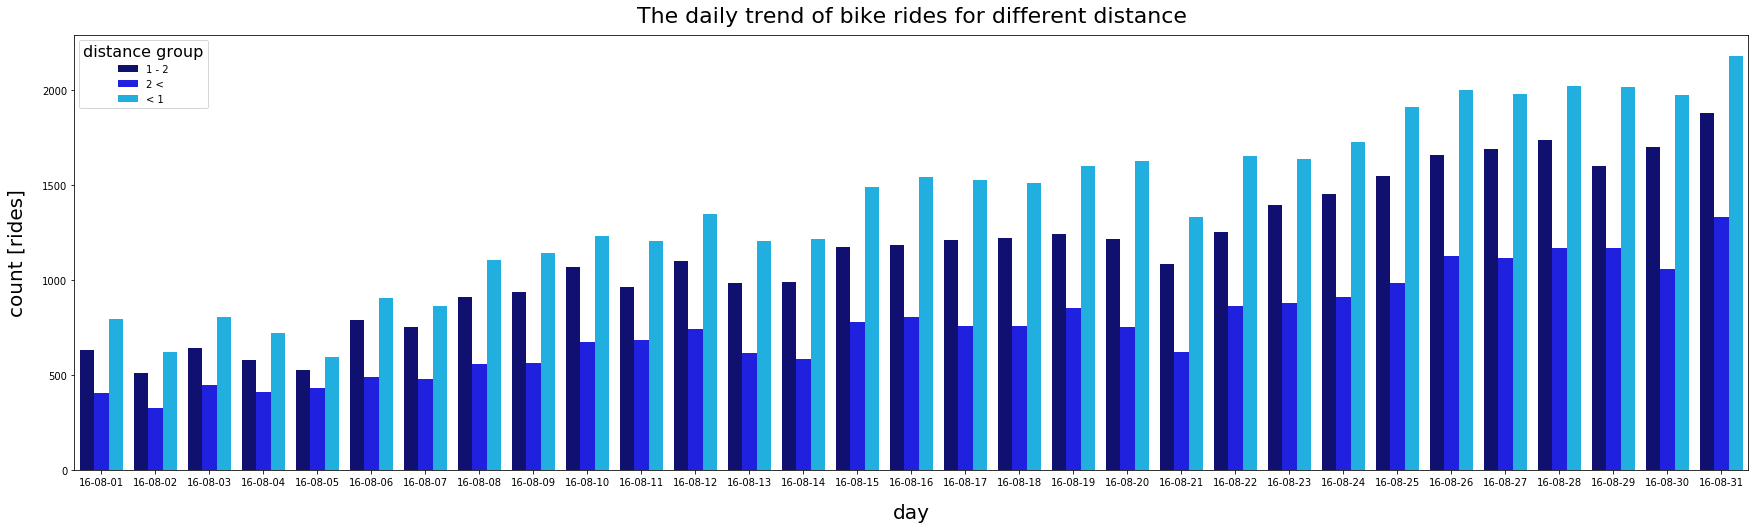

In [36]:
# 8月不同骑行距离的分布趋势
plt.figure(figsize=(30,8))
my_palette = {'< 1': 'deepskyblue', '1 - 2': 'navy', '2 <': 'blue'}
ax = sb.countplot(x='start_time_year_month_day_renamed', hue='distance_km_bins', palette=my_palette, data=df[df['distance_km_bins'].isin(['< 1', '1 - 2', '2 <'])].sort_values(by=['start_time_year_month_day_renamed', 'distance_km_bins']))
plt.title('The daily trend of bike rides for different distance', fontsize=22, y=1.015)
plt.xlabel('day', labelpad=16,fontsize=20)
plt.ylabel('count [rides]', labelpad=16,fontsize=20)
leg = ax.legend()
leg.set_title('distance group',prop={'size':16})


> 我们发现三段距离分类的人群每天的骑行比例非常接近，表明人们的骑行习惯比较固定；每天的变化趋势也几乎一样，变化更多应该收其他因素影响

对骑行距离与骑行时间的关系进行分析

(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

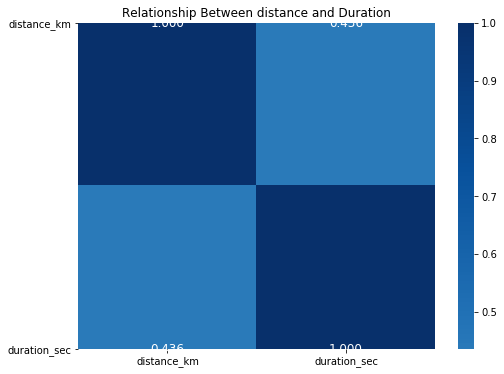

In [37]:
# 骑行距离和骑行时长的相关系数
numeric_vars = ['distance_km','duration_sec']
times_chr = ['period_day','start_weekday_char','start_month_char']
plt.figure(figsize = [8,6])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'Blues', annot_kws={"size": 12},center = 0)
plt.title('Relationship Between distance and Duration');
plt.yticks(rotation=360)

<Figure size 1080x720 with 0 Axes>

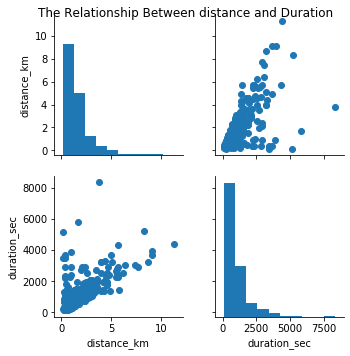

In [38]:
# 对数据集进行抽样，绘制直方图和散点图展示变量关系
samples = np.random.choice(df.shape[0], 500, replace = False)
df_samp = df.loc[samples,:]
plt.figure(figsize=(15,10))
g = sb.PairGrid(data = df_samp, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 10)
g.map_offdiag(plt.scatter)
g.fig.suptitle('The Relationship Between distance and Duration');

> 我们对骑行的距离信息和时长信息做了相关性的分析。我们发现这两个变量存在正的相关性，相关系数为0.436,跟人们的直觉一样，距离长自然时间也会越久。我们通过抽样的散点图和直方图也能看出他们近似的线性关系。

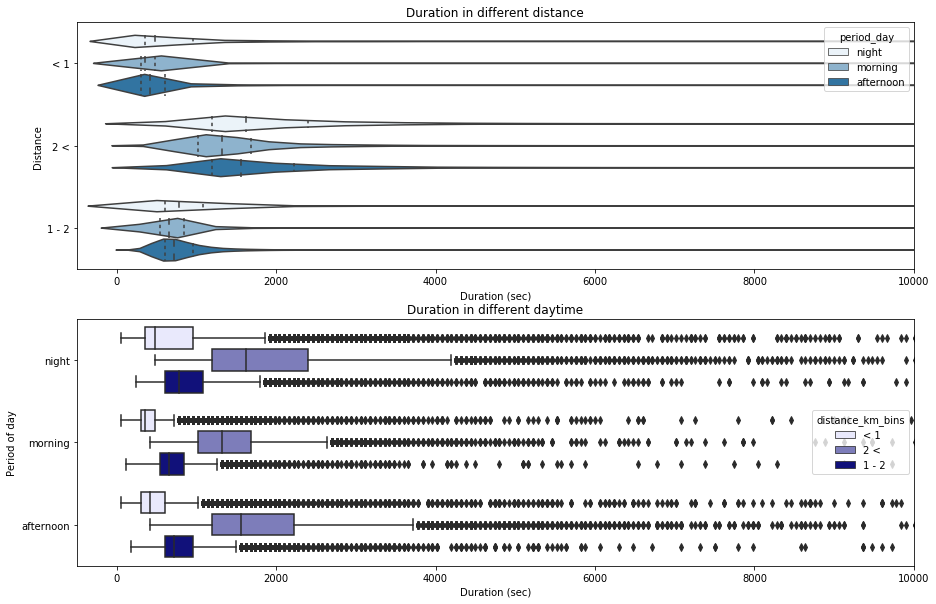

In [39]:
# 用小提琴图观察不同距离中的数量分布关系，以及不同时段中人们骑行时长的分布
plt.figure(figsize=(15,10))
ax = plt.subplot(211)
sb.violinplot(data=df, y='distance_km_bins', x='duration_sec',hue = 'period_day', inner='quartile', color=color1)
plt.xlim(right = 10000,left = -500)
plt.xlabel('Duration (sec)')
plt.ylabel('Distance')
plt.title('Duration in different distance')

ax = plt.subplot(212)
sb.boxplot(data=df, y='period_day', x='duration_sec', hue='distance_km_bins', color='darkblue')
plt.xlim(right = 10000,left = -500)
plt.xlabel('Duration (sec)')
plt.ylabel('Period of day')
plt.title('Duration in different daytime');

>+ 我们发现一个奇怪的现象，小于1公里的骑行人群的用时分布居然跟1-2公里人群的用时分布及其的相似。这两个人群的速度速度是明显的变量，小于1公里的人更多是距离不远也不干时间，1-2公里的人可能需要其更快的速度才能达到目的地。大于2公里的人群的用时明显多于前两群人，可以看出速度是有上线的，要想实现更远的骑行，只能增加时长。

>+ 我们发现一天中早上时段的人群骑行时间整体来说更短，晚上骑行的人群用时相对更长，可以看出早上由于工作的原因，大家都更敢时间，到了下班甚至晚上人们骑行的时长逐渐增加，更加偏运动或者锻炼。

## 多变量分析

对一周内各天每个时段骑行时间的分析

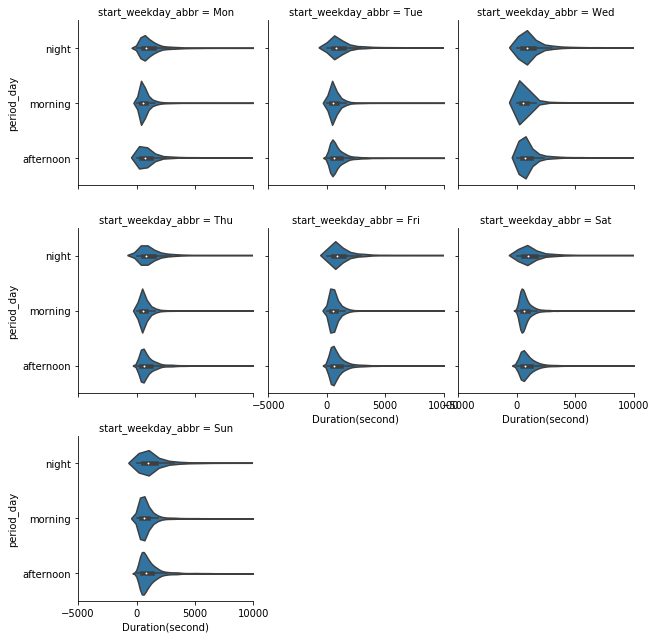

In [56]:
# 绘制一周内按天分布的距离和时间的关系图
g = sb.FacetGrid(data = df, col = 'start_weekday_abbr', col_wrap = 3)
g.map(sb.violinplot, 'duration_sec', 'period_day', color = color1)
plt.xlim(right = 10000)
g.set_xlabels('Duration(second)')
plt.show()

> 我们发现一周内每天各个时段人们的骑行市场还是不同的。能看出来早上时段短时间骑行的人群更集中，但周三可能是个例外，周三各个时段的骑行时间分布比较平均。晚上时段骑行时间较长的人群多一些。